# Limpieza de los set de datos

In [1]:
import datetime as datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('default') # Make the graphs a bit prettier
plt.rcParams['figure.figsize'] = (15, 5)

In [2]:
import os
path_working_directory = os.getcwd()

educacion = pd.read_csv(os.path.join(path_working_directory, "datos_navent_fiuba", "fiuba_1_postulantes_educacion.csv"), low_memory=False)
genero_edad = pd.read_csv(os.path.join(path_working_directory, "datos_navent_fiuba", "fiuba_2_postulantes_genero_y_edad.csv"), low_memory=False)
visitas = pd.read_csv(os.path.join(path_working_directory, "datos_navent_fiuba", "fiuba_3_vistas.csv"), low_memory=False)
postulaciones = pd.read_csv(os.path.join(path_working_directory, "datos_navent_fiuba", "fiuba_4_postulaciones.csv"), low_memory=False)
avisos_online = pd.read_csv(os.path.join(path_working_directory, "datos_navent_fiuba", "fiuba_5_avisos_online.csv"), low_memory=False)
avisos_detalles = pd.read_csv(os.path.join(path_working_directory, "datos_navent_fiuba", "fiuba_6_avisos_detalle.csv"), low_memory=False)

### Set de genero y fechas de nacimiento

In [3]:
print "Cantidad de usuarios:", len(genero_edad), '\n'
print "Los usuarios son unicos:", len(genero_edad) == len(genero_edad.groupby('idpostulante')), '\n'
print genero_edad.isnull().any(), '\n'
print genero_edad.isnull().sum(), '\n'
print genero_edad.dtypes, '\n'

Cantidad de usuarios: 200888 

Los usuarios son unicos: True 

idpostulante       False
fechanacimiento     True
sexo               False
dtype: bool 

idpostulante          0
fechanacimiento    4750
sexo                  0
dtype: int64 

idpostulante       object
fechanacimiento    object
sexo               object
dtype: object 



Como se puede observar, existen 4750 usuarios de 200888 que no declaran su fecha de nacimiento (es decir, aproximadamente un 2,36%). Para que el set de datos este completo se podria rellenar los datos faltantes realizando una regresion o sacando un promedio siguiendo algun tipo de criterio. Sin embargo, como la cantidad de usuarios en cuestion es baja, se los puede eliminar del set de datos. Antes de realizar esto se analizara cuantas postulaciones y visitas corresponden a usuarios sin fecha de nacimiento, para ver si eliminar dichos usuarios implica quitar muchas postulaciones y visitas a avisos de los demas sets de datos.

In [4]:
no_declaran_edad = genero_edad[genero_edad.fechanacimiento.isnull()]
print len(no_declaran_edad), "postulantes no declaran edad", '\n'
declaran_edad = genero_edad[genero_edad.fechanacimiento.notnull()]
print len(declaran_edad), "postulantes declaran edad", '\n'
postulaciones_sin_fecha_nacimiento = pd.merge(no_declaran_edad, postulaciones, how='inner', on='idpostulante')
print len(postulaciones_sin_fecha_nacimiento), "postulaciones de usuarios sin fecha de nacimiento de", len(postulaciones), '\n'
visitas_sin_fecha_nacimiento = pd.merge(no_declaran_edad, visitas, how='inner', on='idpostulante')
print len(visitas_sin_fecha_nacimiento), "visitas de usuarios sin fecha de nacimiento de", len(visitas)

4750 postulantes no declaran edad 

196138 postulantes declaran edad 

44464 postulaciones de usuarios sin fecha de nacimiento de 3401623 

22767 visitas de usuarios sin fecha de nacimiento de 961897


Aproximadamente un 1,31% de las postulaciones corresponden a usuarios sin fecha de nacimiento mientras que en el caso de las visitas es de un 2,37%. Teniendo en cuenta que estos valores son pequenos, podemos optar por eliminar los usuarios sin fecha de nacimiento (y hacer lo propio con sus postulaciones y visitas a avisos)

In [5]:
genero_edad_filtrado = genero_edad[genero_edad.fechanacimiento.notnull()]

In [6]:
len(genero_edad_filtrado)

196138

### Set de estudios

In [7]:
print educacion.isnull().any(), '\n'
print educacion.describe(include='all'), '\n'
print educacion.dtypes, '\n'
print educacion.nombre.value_counts(), '\n'
print educacion.estado.value_counts(), '\n'

idpostulante    False
nombre          False
estado          False
dtype: bool 

       idpostulante      nombre    estado
count        298231      298231    298231
unique       188752           7         3
top          YlMLGD  Secundario  Graduado
freq              9      110256    194474 

idpostulante    object
nombre          object
estado          object
dtype: object 

Secundario           110256
Universitario        104295
Terciario/Técnico     47733
Otro                  24748
Posgrado               7387
Master                 3598
Doctorado               214
Name: nombre, dtype: int64 

Graduado      194474
En Curso       78531
Abandonado     25226
Name: estado, dtype: int64 



Se puede observar que en algunos casos existen multiples entradas de estudio por usuario. A continuacion se analizara el caso del usuario que tiene mas entadas, cuyo id es YlMLGD:

In [8]:
educacion[educacion['idpostulante'] == 'YlMLGD']

,idpostulante,nombre,estado
373,YlMLGD,Terciario/Técnico,En Curso
374,YlMLGD,Otro,En Curso
375,YlMLGD,Universitario,En Curso
2206,YlMLGD,Terciario/Técnico,Graduado
2207,YlMLGD,Universitario,Graduado
2208,YlMLGD,Otro,Graduado
2209,YlMLGD,Posgrado,Graduado
3659,YlMLGD,Universitario,Abandonado
3660,YlMLGD,Terciario/Técnico,Abandonado


Podemos ver que este usuario presenta multiples entradas con estudios con estado En Curso, Graduado y Abandonado. A su vez, aparencen multiples entradas para un mismo tipo de estudio, como es el caso de Universitario.
Para poder analizar mejor los datos de educacion, se opto por generar un dataframe que tenga una fila por cada usuario donde sus columnas sean el id del usuario (idpostulante), el mayor nivel de estudio en el que se graduo (estudio_graduado) y el mayor nivel de estudio que tiene en curso (estudio_en_curso), que a su vez debe ser mayor al nivel que tiene en la columna estudio_graduado.
Se definio que el nivel de estudio, de menor a mayor, sea el siguiente: 
Otro, Secundario, Terciario/Técnico, Universitario, Master, Posgrado y Doctorado.

In [9]:
tipos_de_estudio = ['', 'Otro', 'Secundario', 'Terciario/Técnico', 'Universitario', 'Master', 'Posgrado', 'Doctorado']
def get_dict_tipos_de_estudio():
    dict = {}
    for x in range(len(tipos_de_estudio)):
        dict[tipos_de_estudio[x]] = x
    return dict

dict_tipos_de_estudio = get_dict_tipos_de_estudio()

def mejor_estudio(estudio1, estudio2):
    return tipos_de_estudio[max(tipos_de_estudio.index(estudio1), tipos_de_estudio.index(estudio2))]

en_curso = educacion.apply(lambda x: dict_tipos_de_estudio[x['nombre']] if x['estado'] == 'En Curso' else 0, axis=1)
graduado = educacion.apply(lambda x: dict_tipos_de_estudio[x['nombre']] if x['estado'] == 'Graduado' else 0, axis=1)
educacion2 = educacion.assign(estudio_en_curso=en_curso)
educacion2 = educacion2.assign(estudio_graduado=graduado)

In [10]:
educacion_grupos = educacion2.groupby('idpostulante')
educacion_nueva = pd.DataFrame({
    'estudio_en_curso': educacion_grupos['estudio_en_curso'].max(),
    'estudio_graduado': educacion_grupos['estudio_graduado'].max()
}).reset_index()
# educacion_nueva['estudio_en_curso'] = educacion_nueva['estudio_en_curso'].apply(lambda x: tipos_de_estudio[x])
educacion_nueva['estudio_en_curso'] = educacion_nueva.apply(lambda x: tipos_de_estudio[x['estudio_en_curso']] if x['estudio_en_curso'] > x['estudio_graduado'] else '', axis=1)
educacion_nueva['estudio_graduado'] = educacion_nueva['estudio_graduado'].apply(lambda x: tipos_de_estudio[x])
print len(educacion_nueva)
educacion_nueva[educacion_nueva['idpostulante'] == 'YlMLGD']

188752


,idpostulante,estudio_en_curso,estudio_graduado
117605,YlMLGD,,Posgrado


El usuario YlMLGD no tiene una entrada en la columna de estudio en curso dado que esta graduado en un Posgrado (y su mayor estudio en curso es Universitario, que tiene un menor nivel). 
De esta manera, se tiene una unica entrada por cada usuario y la cantidad de entradas se corresponde con la cantidad de valores unicos en el dataframe original.

Solamente queremos mantener usuarios que tengan informacion sobre su educacion:

In [11]:
usuarios_educacion_edad = pd.merge(genero_edad_filtrado, educacion_nueva, on='idpostulante', how='inner')
len(usuarios_educacion_edad)

185878

Dentro de los usuarios con entradas de educacion, la cantidad de usuarios sin fecha de nacimiento no es alta (2874 de 188752, que es un 1,52%) y dado que se queria realizar un analisis teniendo en cuenta esta informacion, se opto por borrarlos.

In [12]:
postulaciones_total = len(postulaciones)
postulaciones_filtrado = pd.merge(usuarios_educacion_edad, postulaciones, how='inner', on='idpostulante')
print len(postulaciones_filtrado), "postulaciones de usuarios con fecha de nacimiento y educacion de", postulaciones_total, '\n'
visitas_total = len(visitas)
visitas_filtrado = pd.merge(usuarios_educacion_edad, visitas, how='inner', on='idpostulante')
print len(visitas_filtrado), "visitas de usuarios con fecha de nacimiento y educacion de", visitas_total

3268054 postulaciones de usuarios con fecha de nacimiento y educacion de 3401623 

895478 visitas de usuarios con fecha de nacimiento y educacion de 961897


Esto implica que eliminamos el 3,92% de las postulaciones, el 6,91% de las visitas y 7,47% de los usuarios (teniendo en cuenta como total el numero de entradas del csv de genero y edad). Esto se realizo con el fin de tener dataframes de usuarios con su informacion completa (fecha de nacimiento y su educacion)

### Set de datos con detalles de avisos

In [13]:
print len(avisos_detalles), '\n'
print 'Columnas con valores nulos:'
print avisos_detalles.isnull().any(), '\n'
print 'Cantidad de valores nulos por columna'
print avisos_detalles.isnull().sum(), '\n'
print avisos_detalles.dtypes
avisos_detalles.head(1)

13534 

Columnas con valores nulos:
idaviso                 False
idpais                  False
titulo                  False
descripcion             False
nombre_zona             False
ciudad                   True
mapacalle                True
tipo_de_trabajo         False
nivel_laboral           False
nombre_area             False
denominacion_empresa     True
dtype: bool 

Cantidad de valores nulos por columna
idaviso                     0
idpais                      0
titulo                      0
descripcion                 0
nombre_zona                 0
ciudad                  13487
mapacalle               12662
tipo_de_trabajo             0
nivel_laboral               0
nombre_area                 0
denominacion_empresa        5
dtype: int64 

idaviso                  int64
idpais                   int64
titulo                  object
descripcion             object
nombre_zona             object
ciudad                  object
mapacalle               object
tipo_de_trabajo     

,idaviso,idpais,titulo,descripcion,nombre_zona,ciudad,mapacalle,tipo_de_trabajo,nivel_laboral,nombre_area,denominacion_empresa
0,8725750,1,VENDEDOR/A PROVINCIA DE SANTA FE,<p><strong><strong>Empresa:</strong></strong> ...,Gran Buenos Aires,NaN,NaN,Full-time,Senior / Semi-Senior,Comercial,VENTOR


In [14]:
avisos_sin_empresa = avisos_detalles[avisos_detalles.denominacion_empresa.isnull()]
print len(avisos_sin_empresa)
# postulaciones_de_avisos_sin_empresa = pd.merge(

5


### Plots de postulaciones por usuario

In [16]:
postulaciones_por_usuario_filtrado = pd.DataFrame({
    'postulaciones_totales': postulaciones_filtrado.groupby('idpostulante')['idaviso'].count(),
}).reset_index()
postulaciones_por_usuario_filtrado = postulaciones_por_usuario_filtrado.sort_values('postulaciones_totales')
print postulaciones_por_usuario_filtrado.postulaciones_totales.head(5)
print postulaciones_por_usuario_filtrado.postulaciones_totales.tail(5)

155006    1
40700     1
15583     1
159576    1
15581     1
Name: postulaciones_totales, dtype: int64
17657     1213
39789     1414
21841     1485
33610     1773
131087    3166
Name: postulaciones_totales, dtype: int64


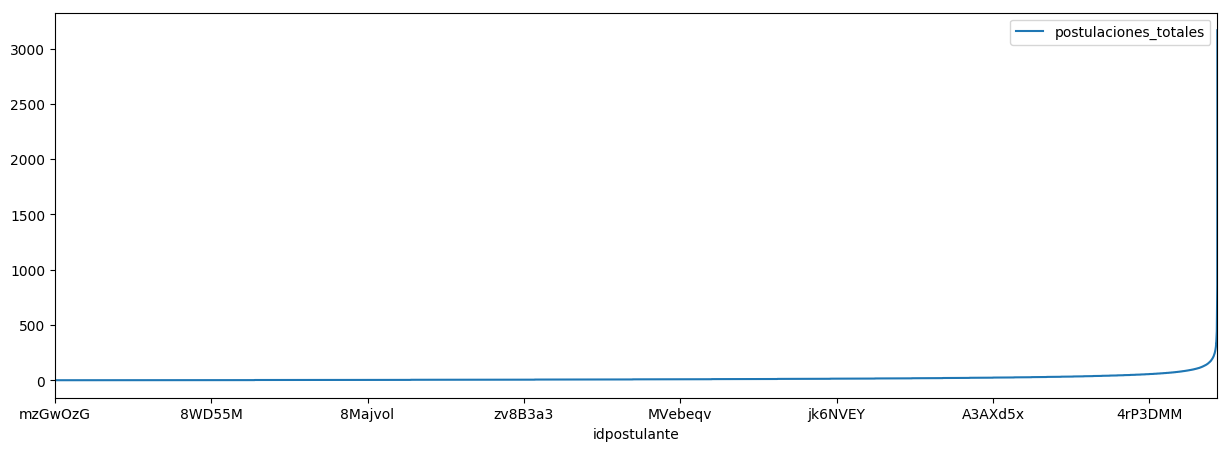

In [17]:
postulaciones_por_usuario_filtrado.plot(x='idpostulante', y='postulaciones_totales', kind='line')

In [19]:
postulaciones_por_usuario_sin_filtro = pd.DataFrame({
    'postulaciones_totales': postulaciones.groupby('idpostulante')['idaviso'].count(),
}).reset_index()
postulaciones_por_usuario_sin_filtro = postulaciones_por_usuario_sin_filtro.sort_values('postulaciones_totales')
print postulaciones_por_usuario_sin_filtro.postulaciones_totales.head(5)
print postulaciones_por_usuario_sin_filtro.postulaciones_totales.tail(5)
len(postulaciones_por_usuario_sin_filtro)

59628     1
137057    1
40544     1
40549     1
94726     1
Name: postulaciones_totales, dtype: int64
19108     1213
42947     1414
23612     1485
36281     1773
141436    3166
Name: postulaciones_totales, dtype: int64


200888

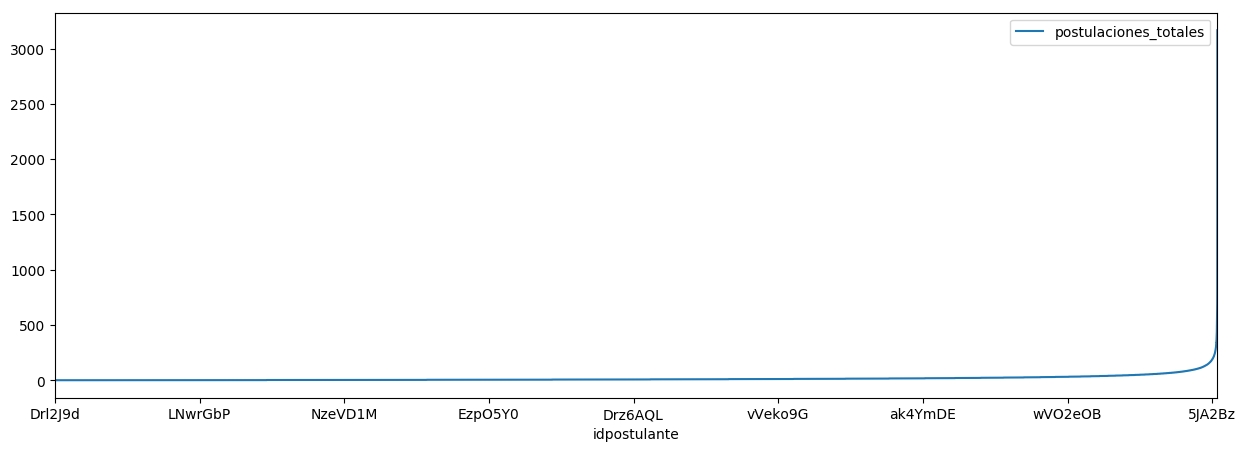

In [20]:
postulaciones_por_usuario_sin_filtro.plot(x='idpostulante', y='postulaciones_totales', kind='line')

In [ ]:
# Como hacer un concat de series y eliminar duplicados
# idaviso_post_sin_fecha_nacimiento = postulaciones_sin_fecha_nacimiento.idaviso
# idaviso_visitas_sin_fecha_nacimiento = visitas_sin_fecha_nacimiento.idAviso
# len(idaviso_post_sin_fecha_nacimiento)
# len(idaviso_visitas_sin_fecha_nacimiento)
# avisos_de_postulantes_sin_fecha_nacimiento = pd.concat([idaviso_post_sin_fecha_nacimiento, idaviso_visitas_sin_fecha_nacimiento], ignore_index=True)
# avisos_de_postulantes_sin_fecha_nacimiento = avisos_de_postulantes_sin_fecha_nacimiento.drop_duplicates()